## Imports

In [137]:
#import copy
import json
import math
#import pprint
import random
#import scipy
import sklearn
#import statistics
import matplotlib.pyplot as plt
import numpy
from scipy.stats import beta
from scipy.optimize import least_squares
from sklearn.metrics import r2_score

## Data loading and preprocessing

In [3]:
ranked_data_path = f"export.json"
ranked_data_file = open(ranked_data_path,encoding="utf-8")
ranked_data = json.load(ranked_data_file)

In [4]:
players = ranked_data["Players"]
maps = ranked_data["Maps"]
scores = ranked_data["Scores"]

In [40]:
min_score = 0.7
filtered_scores = [score for score in scores if score["Accuracy"] > min_score and score["Accuracy"] < 1.0 and score["Modifiers"] == ""]
print(len(scores))
print(len(filtered_scores))
print(len(filtered_scores)/len(scores))

3058785
2656447
0.8684647662388825


In [41]:
players_by_id = {player["Id"] : player for player in players}
maps_by_id = {bmap["Id"] : bmap for bmap in maps}

In [54]:
scores_by_player_id = {}
scores_by_map_id = {}
score_data_by_map_id = {}

def add_score(score):
    player_id = score["PlayerId"]
    map_id = score["LeaderboardId"]
    
    player_map = scores_by_player_id.get(player_id,{})
    player_map[map_id] = score
    
    scores_by_player_id[player_id] = player_map    


    
    map_map = scores_by_map_id.get(map_id,{})
    map_map[player_id] = score
    
    scores_by_map_id[map_id] = map_map   


    
    score_data = score_data_by_map_id.get(map_id,[])

    score_data.append(score["Accuracy"])

    score_data_by_map_id[map_id] = score_data

for score in filtered_scores:
    add_score(score)

## Fitting a map's scores to a beta distribution

In [61]:
def fit_scores_beta(scores):
    (a, b, loc, scale) = beta.fit(scores, floc=0, fscale=1)
    return (a,b)

beta_parameters_per_map = {}

for map_id,scores in score_data_by_map_id.items():
    beta_parameters_per_map[map_id] = fit_scores_beta(scores)

In [125]:
# Using least squares
# Some help from ChatGPT used here (adapted)
def residuals(params, scores):
    scores.sort()
    
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(scores, a, b)
    return model_cdf - empirical_cdf

def fit_scores_beta_least_squares(scores, initial_params):
    residuals_lambda = lambda params:residuals(params,scores)
    
    result = least_squares(residuals_lambda, initial_params)
    
    return result.x

least_squares_beta_parameters_per_map = {}

for map_id,scores in score_data_by_map_id.items():
    initial_params = beta_parameters_per_map[map_id]

    least_squares_beta_parameters_per_map[map_id] = fit_scores_beta_least_squares(scores, initial_params)

## Some metrics for evaluation

In [147]:
# R squared
def r_squared_beta(params, scores):
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    empirical_cdf = numpy.arange(1, len(scores) + 1) / len(scores)
    
    a, b = params
    model_cdf = beta.cdf(scores, a, b)

    return r2_score(empirical_cdf, model_cdf)

# Quantiles
def quantiles_beta(params, scores, n_quantiles):    
    # We presume the scores are sorted for performance!
    #scores.sort()
    
    quantiles = numpy.arange(1, n_quantiles) / n_quantiles

    n = len(scores)    

    def empirical_quantile(quantile):
        return scores[math.floor(n*quantile)]

    a, b = params
    def model_quantile(quantile):
        return beta.ppf(quantile, a, b)        
        
    return {quantile:(empirical_quantile(quantile),model_quantile(quantile)) for quantile in quantiles}

n_quantiles = 10
beta_r_squared_values = {}
beta_quantile_values = {}
least_squares_beta_r_squared_values = {}
least_squares_beta_quantile_values = {}

for map_id,scores in score_data_by_map_id.items():
    params = beta_parameters_per_map[map_id]
    least_squares_params = least_squares_beta_parameters_per_map[map_id]
    
    beta_r_squared_values[map_id] = r_squared_beta(params,scores)
    beta_quantile_values[map_id] = quantiles_beta(params,scores,n_quantiles)
    least_squares_beta_r_squared_values[map_id] = r_squared_beta(least_squares_params,scores)
    least_squares_beta_quantile_values[map_id] = quantiles_beta(least_squares_params,scores,n_quantiles)

## Plots

In [192]:
def show_map_density(map_id):        
    (mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = least_squares_beta_parameters_per_map[map_id]
    
    scores = score_data_by_map_id[map_id]
    
    plt.hist(scores,bins=15,density=True,label="Real scores")
    ml_fitted = lambda x:beta.pdf(x,mla,mlb)
    ls_fitted = lambda x:beta.pdf(x,lsa,lsb)
    
    xx = numpy.linspace(min_score,1,len(scores))
      
    plt.plot(xx,ml_fitted(xx),"g",label="Maximum likelihood estimation")
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")

    map_data = maps_by_id[map_id]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Score density for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty}")
    plt.xlabel("Score percentage")
    plt.ylabel("Proportion of scores")
    plt.legend()
    
    plt.show()

In [193]:
def show_map_distribution(map_id):        
    (mla,mlb) = beta_parameters_per_map[map_id]
    (lsa,lsb) = least_squares_beta_parameters_per_map[map_id]
    
    scores = score_data_by_map_id[map_id]
    
    plt.hist(scores,bins=15,density=True,cumulative=True,label="Cumulative real scores")
    ml_fitted = lambda x:beta.cdf(x,mla,mlb)
    ls_fitted = lambda x:beta.cdf(x,lsa,lsb)
    
    xx = numpy.linspace(min_score,1,len(scores))
    
    plt.plot(xx,ml_fitted(xx),"g",label="Maximum likelihood estimation")
    plt.plot(xx,ls_fitted(xx),"r",label="Least squares estimation")

    map_data = maps_by_id[map_id]
    map_name = map_data["Name"]
    map_mapper = map_data["Mapper"]
    map_mode = map_data["ModeName"]
    map_difficulty = map_data["DifficultyName"]
    
    plt.title(f"Proposed PP curve shape for {map_name} (by {map_mapper}) - {map_mode} {map_difficulty}")
    plt.xlabel("Score percentage")
    plt.ylabel("PP weight")
    plt.legend()
    
    plt.show()

## Results exploration

In [164]:
def map_summary(map_id):
    map_data = maps_by_id[map_id]
    print(map_data)
    print(f"Maximum likelihood estimator: {beta_parameters_per_map[map_id]}")
    print(f"Maximum likelihood R squared: {beta_r_squared_values[map_id]}")
    print(f"Maximum likelihood quantiles: {beta_quantile_values[map_id]}")
    print(f"Least squares estimator: {least_squares_beta_parameters_per_map[map_id]}")
    print(f"Least squares R squared: {least_squares_beta_r_squared_values[map_id]}")
    print(f"Least squares quantiles: {least_squares_beta_quantile_values[map_id]}")    
    show_map_density(map_id)
    show_map_distribution(map_id)

def random_map_summary():
    random_map = random.choice(maps)
    map_id = random_map["Id"]
    map_summary(map_id)

In [183]:
best_r_squared_map_id = None
best_r_squared = None
worst_r_squared_map_id = None
worst_r_squared = None
worst_quantile_map_id = None
worst_quantile_quantile = None
worst_quantile_diff = None
worst_quantile_real = None
worst_quantile_estimated = None

for map_id in maps_by_id:
    r_squared = least_squares_beta_r_squared_values[map_id]
    quantile_values = least_squares_beta_quantile_values[map_id]

    if best_r_squared_map_id is None or r_squared > best_r_squared:
        best_r_squared_map_id = map_id
        best_r_squared = r_squared

    if worst_r_squared_map_id is None or r_squared < worst_r_squared:
        worst_r_squared_map_id = map_id
        worst_r_squared = r_squared

    for quantile,quantile_values in least_squares_beta_quantile_values[map_id].items():
        quantile_diff = abs(quantile_values[0]-quantile_values[1])

        if worst_quantile_map_id is None or quantile_diff > worst_quantile_diff:
            worst_quantile_map_id = map_id
            worst_quantile_quantile = quantile
            worst_quantile_diff = quantile_diff
            worst_quantile_real = quantile_values[0]
            worst_quantile_estimate = quantile_values[1]

{'Hash': '2e6cb362f31d00ee9f2b9c8640cfd94bbfb8377f', 'Name': 'Astronomia', 'CoverImage': 'https://eu.cdn.beatsaver.com/2e6cb362f31d00ee9f2b9c8640cfd94bbfb8377f.jpg', 'Mapper': 'That_Narwhal', 'Id': 'e2ba51', 'SongId': 'e2ba', 'ModeName': 'Standard', 'DifficultyName': 'Hard', 'AccRating': 6.3108873, 'PassRating': 2.8998866, 'TechRating': 2.2210298, 'PredictedAcc': 0.9861392, 'ModifiersRating': {'Id': 8995, 'SSPredictedAcc': 0.9876936, 'SSPassRating': 2.2833197, 'SSAccRating': 5.730306, 'SSTechRating': 1.9112805, 'SSStars': 3.7183127, 'FSPredictedAcc': 0.9841408, 'FSPassRating': 3.7498677, 'FSAccRating': 7.0991454, 'FSTechRating': 2.5552156, 'FSStars': 5.1944942, 'SFPredictedAcc': 0.9812729, 'SFPassRating': 5.1238756, 'SFAccRating': 8.213132, 'SFTechRating': 2.9561396, 'SFStars': 6.5090494, 'BFSPredictedAcc': 0.9850828, 'BFSPassRating': 3.7834702, 'BFSAccRating': 6.5868015, 'BFSTechRating': 2.5665636, 'BFSStars': 4.819439, 'BSFPredictedAcc': 0.982383, 'BSFPassRating': 5.158939, 'BSFAccRa

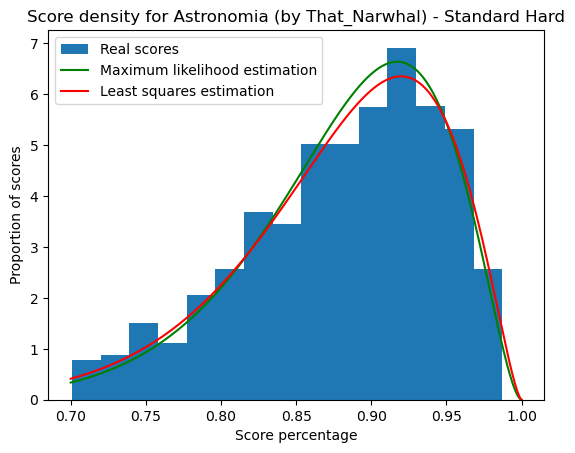

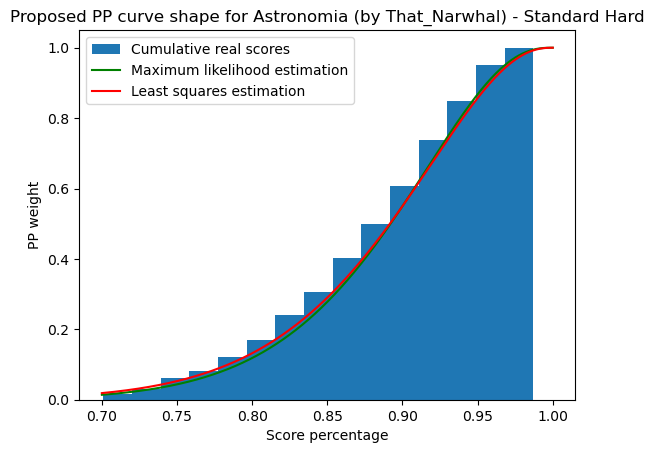

In [194]:
map_summary(best_r_squared_map_id)

{'Hash': '5868546dd2a98e6f0bc288a83506eb766113a9eb', 'Name': 'Forever', 'CoverImage': 'https://eu.cdn.beatsaver.com/5868546dd2a98e6f0bc288a83506eb766113a9eb.jpg', 'Mapper': 'Teuflum & muffn', 'Id': '1a56811', 'SongId': '1a568', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 4.844245, 'PassRating': 0.6914607, 'TechRating': 0.84012985, 'PredictedAcc': 0.9907359, 'ModifiersRating': {'Id': 7059, 'SSPredictedAcc': 0.9913616, 'SSPassRating': 0.52257466, 'SSAccRating': 4.582884, 'SSTechRating': 0.65259993, 'SSStars': 2.3211396, 'FSPredictedAcc': 0.9895627, 'FSPassRating': 0.93920034, 'FSAccRating': 5.305849, 'FSTechRating': 1.0966369, 'FSStars': 2.9676778, 'SFPredictedAcc': 0.987923, 'SFPassRating': 1.3487837, 'SFAccRating': 5.9963307, 'SFTechRating': 1.4765091, 'SFStars': 3.601074, 'BFSPredictedAcc': 0.99013305, 'BFSPassRating': 0.96056956, 'BFSAccRating': 4.680378, 'BFSTechRating': 1.117777, 'BFSStars': 2.565622, 'BSFPredictedAcc': 0.9889618, 'BSFPassRating': 1.3791386, 'BSF

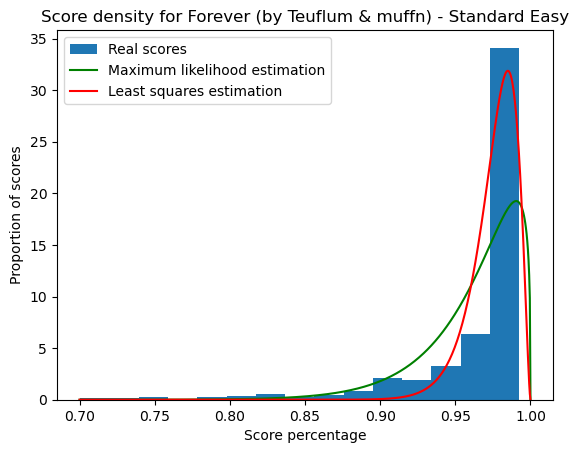

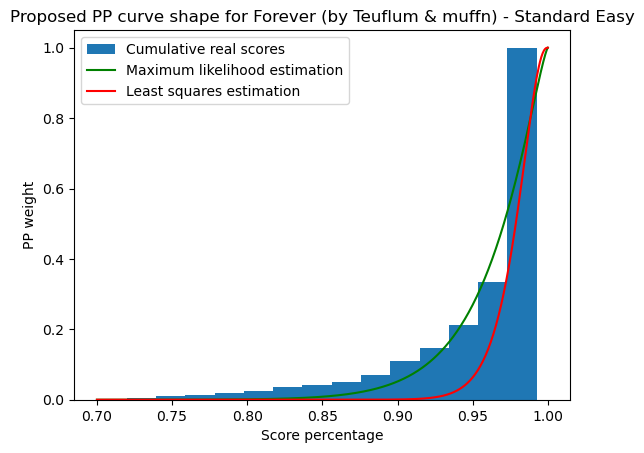

In [195]:
map_summary(worst_r_squared_map_id)

{'Hash': 'C200AD858AFF7C2AC0127616E3221497F5E82CF0', 'Name': 'Halo Reach - Lone Wolf', 'CoverImage': 'https://eu.cdn.beatsaver.com/c200ad858aff7c2ac0127616e3221497f5e82cf0.jpg', 'Mapper': 'Sp234', 'Id': '2812fxx31', 'SongId': '2812fxx', 'ModeName': 'Standard', 'DifficultyName': 'Normal', 'AccRating': 4.308947, 'PassRating': 0.71184963, 'TechRating': 0.7534237, 'PredictedAcc': 0.99131143, 'ModifiersRating': {'Id': 10149, 'SSPredictedAcc': 0.9919358, 'SSPassRating': 0.53735805, 'SSAccRating': 4.08792, 'SSTechRating': 0.5850832, 'SSStars': 2.011176, 'FSPredictedAcc': 0.9904466, 'FSPassRating': 0.96821284, 'FSAccRating': 4.657745, 'FSTechRating': 0.9834949, 'FSStars': 2.5375733, 'SFPredictedAcc': 0.9891225, 'SFPassRating': 1.3927765, 'SFAccRating': 5.125539, 'SFTechRating': 1.3234586, 'SFStars': 2.9989188, 'BFSPredictedAcc': 0.99084526, 'BFSPassRating': 0.98629063, 'BFSAccRating': 4.4004793, 'BFSTechRating': 0.99898183, 'BFSStars': 2.3799057, 'BSFPredictedAcc': 0.9899094, 'BSFPassRating': 

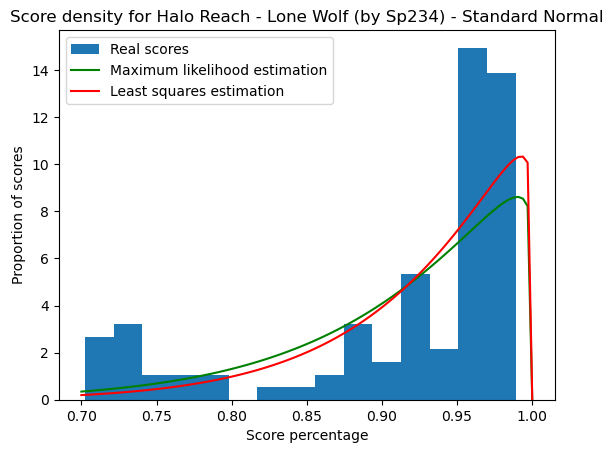

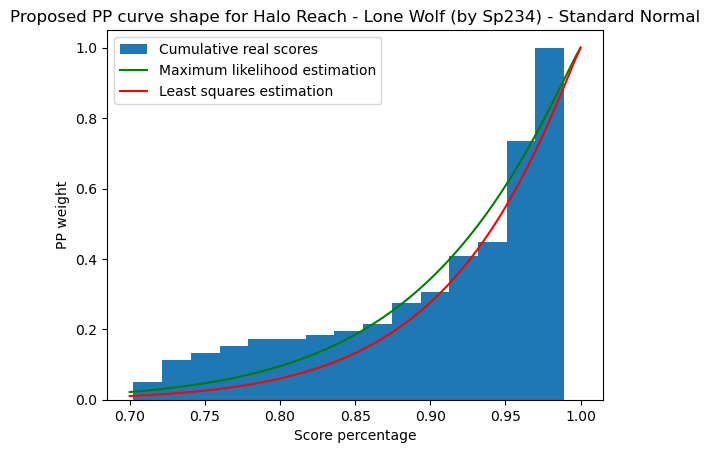

In [196]:
map_summary(worst_quantile_map_id)

{'Hash': 'f402008042efaca4291a6633ebb6b562e4adcd87', 'Name': 'Ov Sacrament and Sincest', 'CoverImage': 'https://eu.cdn.beatsaver.com/f402008042efaca4291a6633ebb6b562e4adcd87.jpg', 'Mapper': 'Rogdude', 'Id': 'c32d91', 'SongId': 'c32d', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.452999, 'PassRating': 12.574544, 'TechRating': 3.1434433, 'PredictedAcc': 0.9666001, 'ModifiersRating': {'Id': 8850, 'SSPredictedAcc': 0.9698934, 'SSPassRating': 10.590675, 'SSAccRating': 11.777966, 'SSTechRating': 3.0994165, 'SSStars': 11.43603, 'FSPredictedAcc': 0.9622678, 'FSPassRating': 15.899232, 'FSAccRating': 13.254593, 'FSTechRating': 3.3226414, 'FSStars': 15.173468, 'SFPredictedAcc': 0.95544827, 'SFPassRating': 21.294296, 'SFAccRating': 14.294328, 'SFTechRating': 3.5666428, 'SFStars': 19.17921, 'BFSPredictedAcc': 0.956516, 'BFSPassRating': 16.298454, 'BFSAccRating': 13.797754, 'BFSTechRating': 3.4141693, 'BFSStars': 15.916871, 'BSFPredictedAcc': 0.9474555, 'BSFPassRating': 21

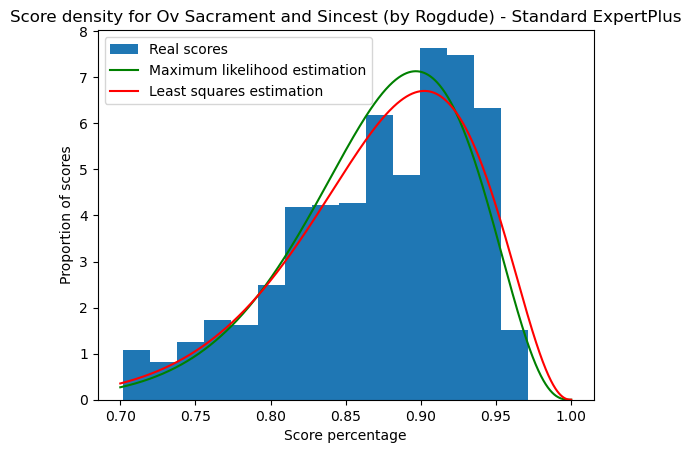

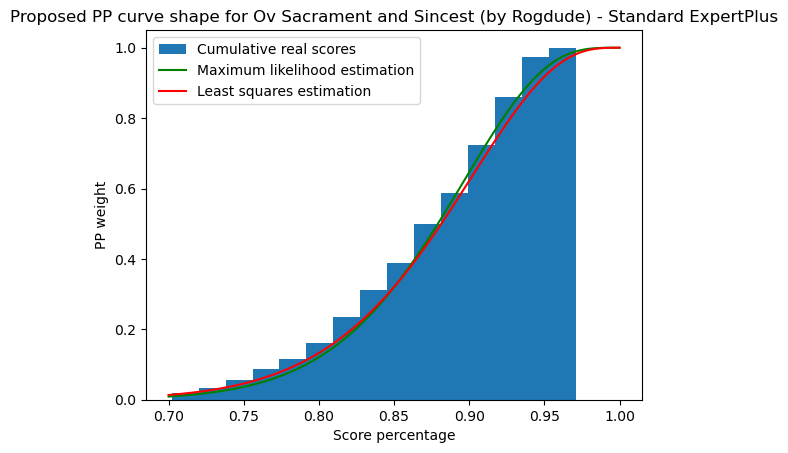

{'Hash': '547d15e033e7c3480428d3a0508f1b7ce50da5d6', 'Name': '666', 'CoverImage': 'https://na.cdn.beatsaver.com/547d15e033e7c3480428d3a0508f1b7ce50da5d6.jpg', 'Mapper': 'ComplexFrequency & Narwhal', 'Id': '2ee3bxxxxxx91', 'SongId': '2ee3bxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.862437, 'PassRating': 12.594467, 'TechRating': 8.803961, 'PredictedAcc': 0.9643922, 'ModifiersRating': {'Id': 1098426, 'SSPredictedAcc': 0.96637076, 'SSPassRating': 10.578978, 'SSAccRating': 12.494317, 'SSTechRating': 8.6788, 'SSStars': 13.022665, 'FSPredictedAcc': 0.96192956, 'FSPassRating': 15.413415, 'FSAccRating': 13.305814, 'FSTechRating': 8.986385, 'FSStars': 15.9848585, 'SFPredictedAcc': 0.957942, 'SFPassRating': 20.558159, 'SFAccRating': 13.940844, 'SFTechRating': 9.587521, 'SFStars': 19.491306, 'BFSPredictedAcc': 0.95723855, 'BFSPassRating': 16.56289, 'BFSAccRating': 13.699425, 'BFSTechRating': 9.150749, 'BFSStars': 16.974865, 'BSFPredictedAcc': 0.95135593, 'BSFPa

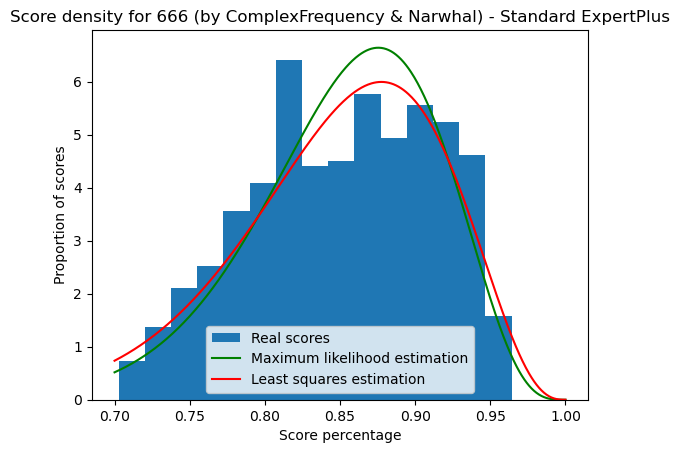

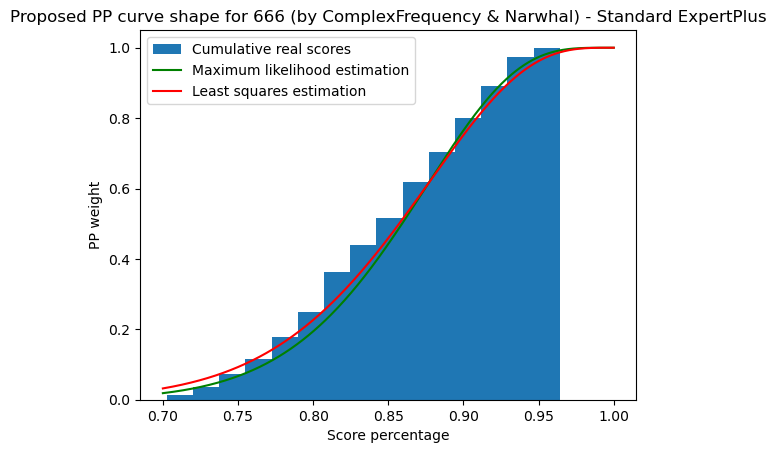

{'Hash': '4963752d07b806f9b0028d0015dc7e65bb74a1c8', 'Name': 'Quiet Water', 'CoverImage': 'https://eu.cdn.beatsaver.com/4963752d07b806f9b0028d0015dc7e65bb74a1c8.jpg', 'Mapper': 'Whiisper', 'Id': '7e8f11', 'SongId': '7e8f', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 1.849692, 'PassRating': 0.017607981, 'TechRating': 0.006381757, 'PredictedAcc': 0.9972797, 'ModifiersRating': {'Id': 8598, 'SSPredictedAcc': 0.997525, 'SSPassRating': 0.012998902, 'SSAccRating': 1.7740775, 'SSTechRating': 0.004714915, 'SSStars': 0.63929594, 'FSPredictedAcc': 0.99700767, 'FSPassRating': 0.024645664, 'FSAccRating': 1.9414564, 'FSTechRating': 0.008921906, 'FSStars': 0.7191181, 'SFPredictedAcc': 0.9965727, 'SFPassRating': 0.036929652, 'SFAccRating': 2.0723765, 'SFTechRating': 0.013341245, 'SFStars': 0.78312385, 'BFSPredictedAcc': 0.9972922, 'BFSPassRating': 0.0285304, 'BFSAccRating': 2.1983514, 'BFSTechRating': 0.01032147, 'BFSStars': 0.84522176, 'BSFPredictedAcc': 0.9969696, 'BSFPassRating':

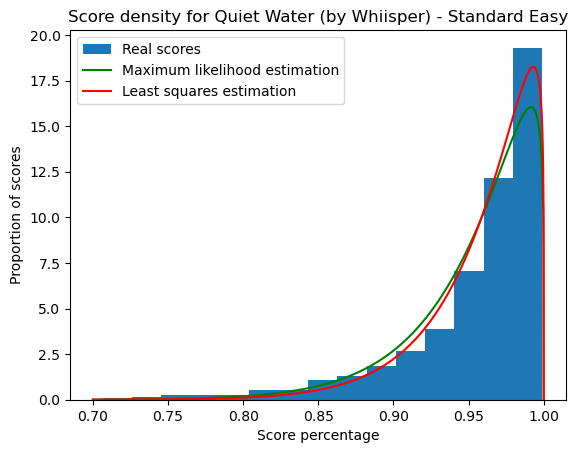

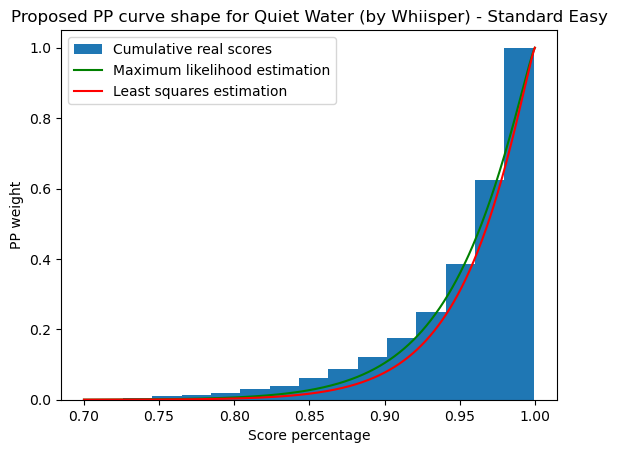

{'Hash': 'b97774a83bdfd669e1bd231039cccfa1162efa13', 'Name': 'Accelerate', 'CoverImage': 'https://na.cdn.beatsaver.com/b97774a83bdfd669e1bd231039cccfa1162efa13.jpg', 'Mapper': 'GalaxyMaster & Phøenix', 'Id': '36bce91', 'SongId': '36bce', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.033914, 'PassRating': 10.752386, 'TechRating': 11.006353, 'PredictedAcc': 0.9635087, 'ModifiersRating': {'Id': 1040275, 'SSPredictedAcc': 0.96533877, 'SSPassRating': 8.980194, 'SSAccRating': 12.683652, 'SSTechRating': 10.758843, 'SSStars': 12.929366, 'FSPredictedAcc': 0.9612418, 'FSPassRating': 13.06871, 'FSAccRating': 13.411184, 'FSTechRating': 11.170669, 'FSStars': 15.3816395, 'SFPredictedAcc': 0.957935, 'SFPassRating': 16.974102, 'SFAccRating': 13.942015, 'SFTechRating': 11.603688, 'SFStars': 17.873146, 'BFSPredictedAcc': 0.9577731, 'BFSPassRating': 13.354142, 'BFSAccRating': 13.627579, 'BFSTechRating': 11.4032135, 'BFSStars': 15.762796, 'BSFPredictedAcc': 0.95211947, 'BSFPassRa

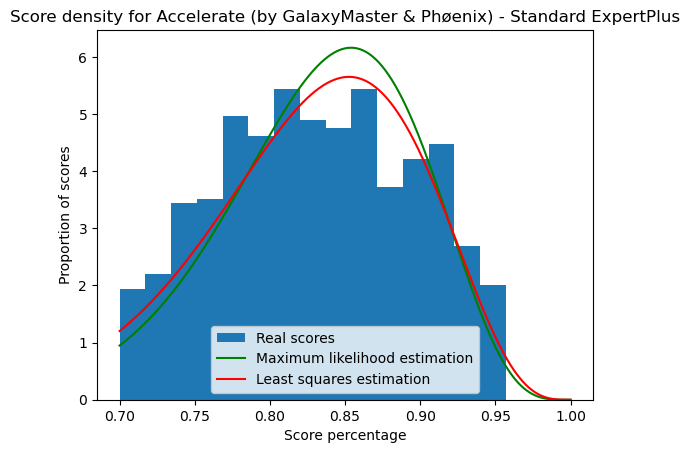

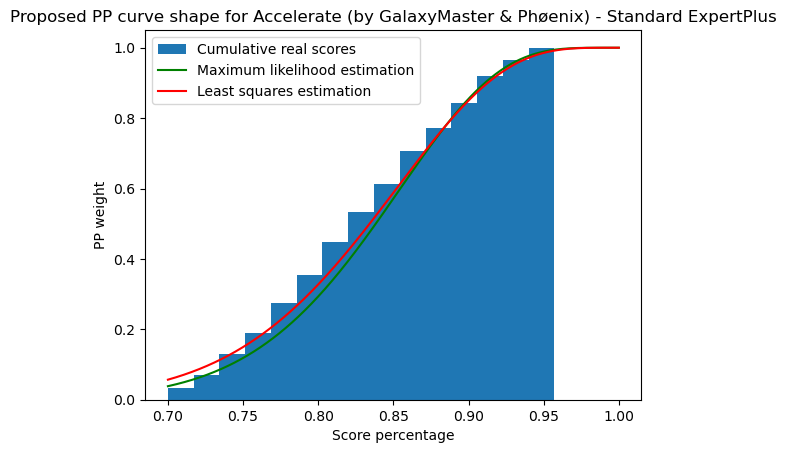

{'Hash': 'C2A5083F21B656EA2B5DB5F689240C39774F8119', 'Name': 'Ludicrous Speed', 'CoverImage': 'https://eu.cdn.beatsaver.com/c2a5083f21b656ea2b5db5f689240c39774f8119.jpg', 'Mapper': 'Helloiamdaan, cerret & Olaf', 'Id': '1f6b1xxxxxxxx91', 'SongId': '1f6b1xxxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 11.938913, 'PassRating': 13.142659, 'TechRating': 2.4304786, 'PredictedAcc': 0.9691477, 'ModifiersRating': {'Id': 7560, 'SSPredictedAcc': 0.9718953, 'SSPassRating': 11.079212, 'SSAccRating': 11.270875, 'SSTechRating': 2.4008696, 'SSStars': 11.051611, 'FSPredictedAcc': 0.96566355, 'FSPassRating': 16.416653, 'FSAccRating': 12.623446, 'FSTechRating': 2.5362573, 'FSStars': 14.677316, 'SFPredictedAcc': 0.96031415, 'SFPassRating': 21.935665, 'SFAccRating': 13.555963, 'SFTechRating': 2.7149062, 'SFStars': 18.654512, 'BFSPredictedAcc': 0.96223223, 'BFSPassRating': 17.520617, 'BFSAccRating': 12.936552, 'BFSTechRating': 2.5808072, 'BFSStars': 15.54242, 'BSFPredictedAcc

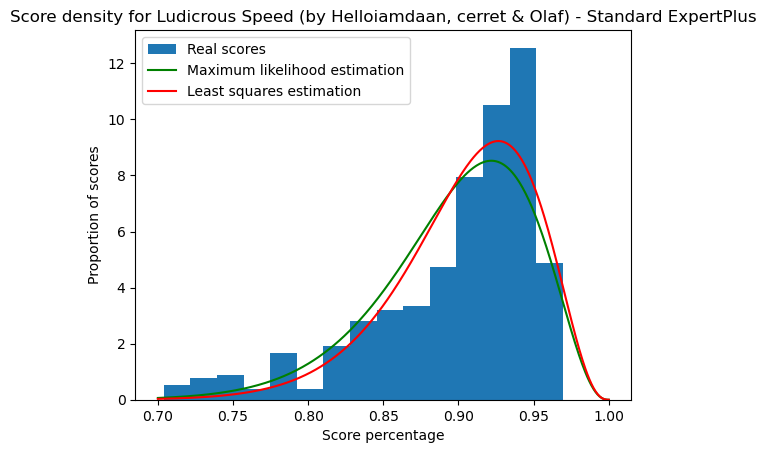

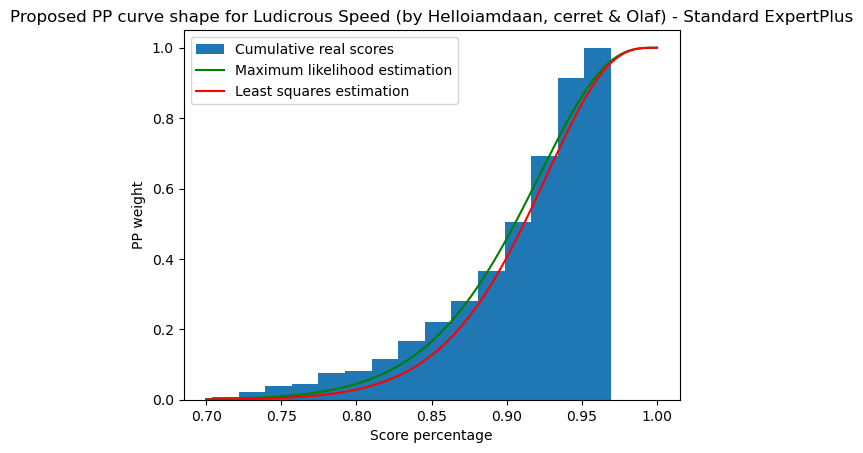

{'Hash': 'C3CFED196F96B161C0862EC387E0EE9241CD5B48', 'Name': 'Novablast', 'CoverImage': 'https://eu.cdn.beatsaver.com/c3cfed196f96b161c0862ec387e0ee9241cd5b48.jpg', 'Mapper': 'Bitz, Cokeinjector, Luck & Sync', 'Id': '23596xxx91', 'SongId': '23596xxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.352792, 'PassRating': 9.229344, 'TechRating': 7.588059, 'PredictedAcc': 0.9671628, 'ModifiersRating': {'Id': 7756, 'SSPredictedAcc': 0.9692271, 'SSPassRating': 7.654591, 'SSAccRating': 11.921572, 'SSTechRating': 7.3393674, 'SSStars': 11.174194, 'FSPredictedAcc': 0.9645801, 'FSPassRating': 11.283625, 'FSAccRating': 12.826547, 'FSTechRating': 7.7656817, 'FSStars': 13.466044, 'SFPredictedAcc': 0.96068, 'SFPassRating': 15.15156, 'SFAccRating': 13.498491, 'SFTechRating': 8.351992, 'SFStars': 15.935818, 'BFSPredictedAcc': 0.961079, 'BFSPassRating': 12.113143, 'BFSAccRating': 13.108646, 'BFSTechRating': 8.013302, 'BFSStars': 14.123602, 'BSFPredictedAcc': 0.954904, 'BSFPassRa

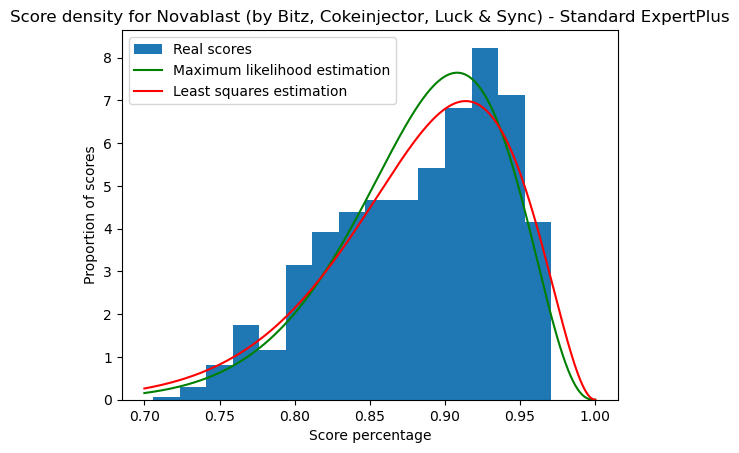

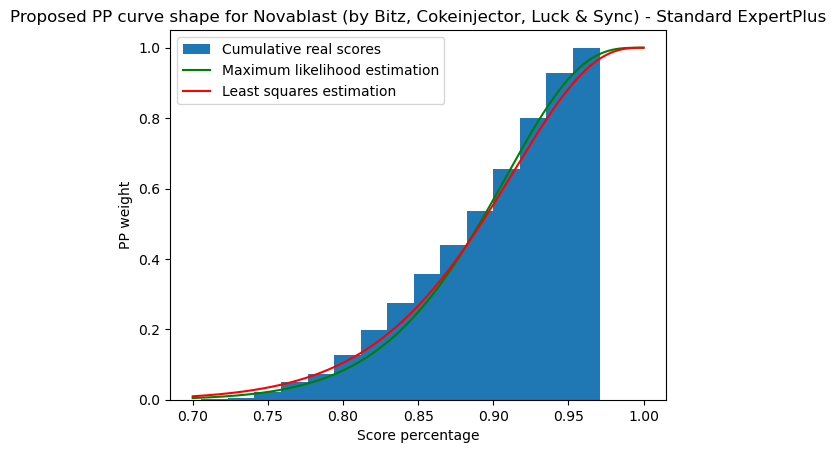

{'Hash': '9A33B85AF39D74C590036E9E8E92060B4FDEDFBD', 'Name': '""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""', 'CoverImage': 'https://eu.cdn.beatsaver.com/9a33b85af39d74c590036e9e8e92060b4fdedfbd.jpg', 'Mapper': 'Vilawes', 'Id': '2cf6391', 'SongId': '2cf63', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 8.789539, 'PassRating': 15.426448, 'TechRating': 1.953545, 'PredictedAcc': 0.9779913, 'ModifiersRating': {'Id': 8284, 'SSPredictedAcc': 0.98016113, 'SSPassRating': 13.070849, 'SSAccRating': 8.068162, 'SSTechRating': 1.9403174, 'SSStars': 8.933409, 'FSPredictedAcc': 0.9752563, 'FSPassRating': 18.985346, 'FSAccRating': 9.631505, 'FSTechRating': 2.0077035, 'FSStars': 13.027602, 'SFPredictedAcc': 0.9713166, 'SFPassRating': 25.277428, 'SFAccRating': 10.647221, 'SFTechRating': 2.1404138, 'SFStars': 17.717543, 'BFSPredictedAcc': 0.9716948, 'BFSPassRating': 19.562475, 'BFSAccRating': 11.045979, 'BFSTechRating': 2.0432973, 'BFSStars': 14.683779, 'BSFP

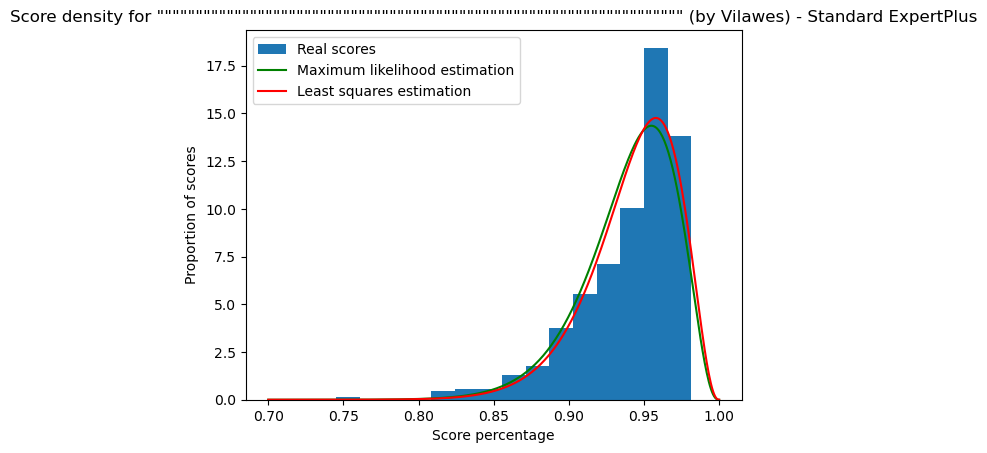

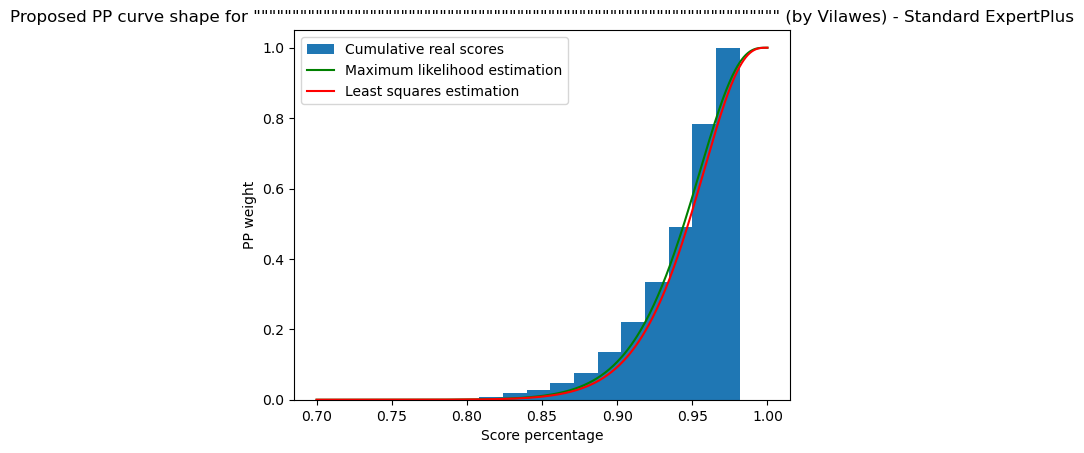

{'Hash': '2712a515d8fefb9c06cd0f8fb7021e7d5da3f2d1', 'Name': 'Dual Doom Deathmatch', 'CoverImage': 'https://cdn.beatsaver.com/2712a515d8fefb9c06cd0f8fb7021e7d5da3f2d1.jpg', 'Mapper': 'Blackjack', 'Id': '3e2c2xxxxx91', 'SongId': '3e2c2xxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 13.393936, 'PassRating': 13.197565, 'TechRating': 11.08773, 'PredictedAcc': 0.9613536, 'ModifiersRating': {'Id': 1233026, 'SSPredictedAcc': 0.96317434, 'SSPassRating': 11.116317, 'SSAccRating': 13.100003, 'SSTechRating': 10.953567, 'SSStars': 14.2033825, 'FSPredictedAcc': 0.9591188, 'FSPassRating': 15.936348, 'FSAccRating': 13.747217, 'FSTechRating': 11.167368, 'FSStars': 17.069088, 'SFPredictedAcc': 0.95562214, 'SFPassRating': 21.203966, 'SFAccRating': 14.269415, 'SFTechRating': 11.879003, 'SFStars': 20.647152, 'BFSPredictedAcc': 0.95505947, 'BFSPassRating': 16.6403, 'BFSAccRating': 14.000344, 'BFSTechRating': 11.416222, 'BFSStars': 17.725101, 'BSFPredictedAcc': 0.94912535, 'BSFP

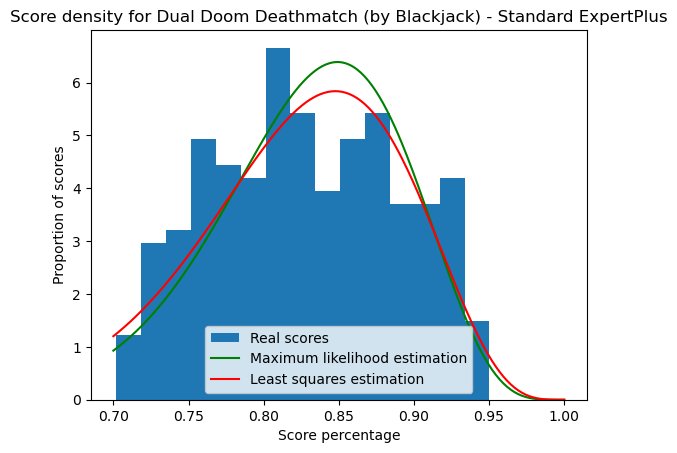

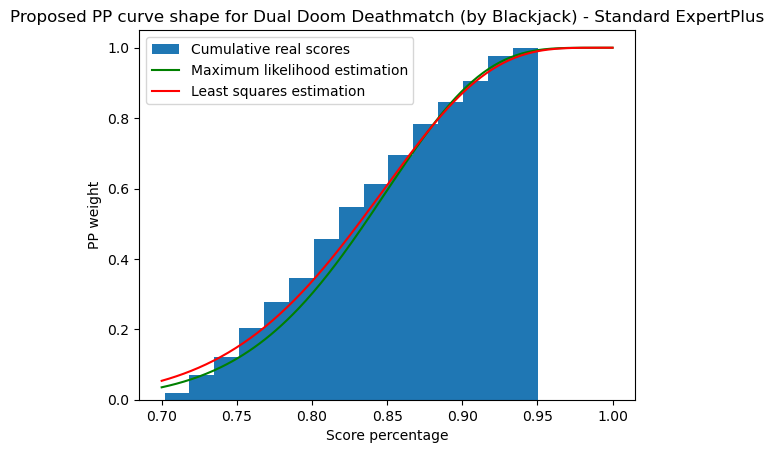

{'Hash': '187bea15de6bd730123917f889c2690a1500433c', 'Name': 'nieuwe tune', 'CoverImage': 'https://cdn.beatsaver.com/187bea15de6bd730123917f889c2690a1500433c.jpg', 'Mapper': 'Stupidity-101', 'Id': '3bcf5xxxxxxxx91', 'SongId': '3bcf5xxxxxxxx', 'ModeName': 'Standard', 'DifficultyName': 'ExpertPlus', 'AccRating': 12.55551, 'PassRating': 13.282304, 'TechRating': 10.852338, 'PredictedAcc': 0.96603376, 'ModifiersRating': {'Id': 1222925, 'SSPredictedAcc': 0.967761, 'SSPassRating': 11.160863, 'SSAccRating': 12.248008, 'SSTechRating': 10.721307, 'SSStars': 13.371577, 'FSPredictedAcc': 0.9637907, 'FSPassRating': 16.06466, 'FSAccRating': 12.978677, 'FSTechRating': 10.928797, 'FSStars': 16.326294, 'SFPredictedAcc': 0.9603623, 'SFPassRating': 21.243496, 'SFAccRating': 13.548368, 'SFTechRating': 11.541488, 'SFStars': 19.858559, 'BFSPredictedAcc': 0.9608965, 'BFSPassRating': 16.882214, 'BFSAccRating': 13.1363, 'BFSTechRating': 11.120437, 'BFSStars': 16.92973, 'BSFPredictedAcc': 0.955367, 'BSFPassRati

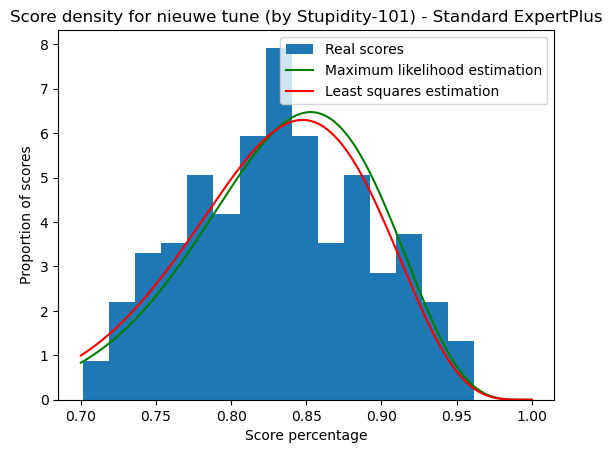

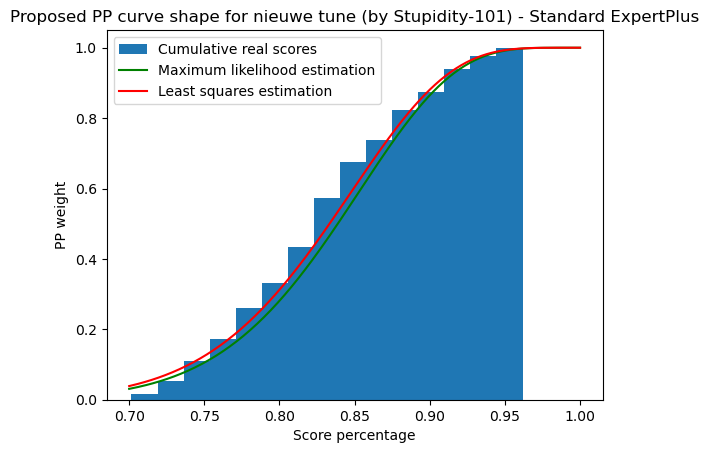

In [197]:
# Some well known maps
golden_standard_map_ids = ["c32d91","2ee3bxxxxxx91","7e8f11","36bce91","1f6b1xxxxxxxx91","23596xxx91","2cf6391","3e2c2xxxxx91","3bcf5xxxxxxxx91"]

for map_id in golden_standard_map_ids:
    map_summary(map_id)

## Dirty testing

In [69]:
filtered_scores[25000]

{'Id': 9029969,
 'LeaderboardId': '1695b31',
 'Accuracy': 0.7597153,
 'Modifiers': '',
 'PlayerId': '76561198129756000',
 'Timepost': 1694226259,
 'FC': False,
 'FCAcc': 0.9008992}

In [50]:
list(scores_by_map_id["1e0b511"].values())[0]

{'Id': 11208864,
 'LeaderboardId': '1e0b511',
 'Accuracy': 0.91385365,
 'Modifiers': '',
 'PlayerId': '76561199552394550',
 'Timepost': 1703233783,
 'FC': True,
 'FCAcc': 0.91385365}

In [56]:
len(score_data_by_map_id["7b3031"])

1263

In [59]:
a1, b1, loc1, scale1 = beta.fit(score_data_by_map_id["1e0b511"], floc=0, fscale=1)

print(a1,b1,loc1,scale1)

33.92043139179413 1.5089826414045566 0 1


In [70]:
beta_parameters_per_map["1695b31"]

(19.426160617247593, 1.9530299835313356)

In [172]:
maps_by_id["1695b31"]

{'Hash': '0b71ba47deef78a55c5709058abdb9b0849486f7',
 'Name': 'I',
 'CoverImage': 'https://eu.cdn.beatsaver.com/0b71ba47deef78a55c5709058abdb9b0849486f7.jpg',
 'Mapper': 'Mystikmol & Moriik',
 'Id': '1695b31',
 'SongId': '1695b',
 'ModeName': 'Standard',
 'DifficultyName': 'Normal',
 'AccRating': 5.876784,
 'PassRating': 2.424829,
 'TechRating': 1.8345768,
 'PredictedAcc': 0.9872711,
 'ModifiersRating': {'Id': 6653,
  'SSPredictedAcc': 0.98847115,
  'SSPassRating': 1.9027168,
  'SSAccRating': 5.403316,
  'SSTechRating': 1.5552086,
  'SSStars': 3.3483102,
  'FSPredictedAcc': 0.9856309,
  'FSPassRating': 3.14529,
  'FSAccRating': 6.526606,
  'FSTechRating': 2.1477187,
  'FSStars': 4.548198,
  'SFPredictedAcc': 0.9832874,
  'SFPassRating': 4.2490406,
  'SFAccRating': 7.4459705,
  'SFTechRating': 2.501836,
  'SFStars': 5.5909376,
  'BFSPredictedAcc': 0.986208,
  'BFSPassRating': 3.220641,
  'BFSAccRating': 6.1294746,
  'BFSTechRating': 2.176296,
  'BFSStars': 4.281431,
  'BSFPredictedAcc':

In [93]:
residuals(beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

array([ 0.00410064,  0.00225577,  0.00022302, -0.00100882, -0.00224014,
       -0.00389426, -0.00451915, -0.00628912, -0.00781758, -0.00935312,
       -0.0084509 , -0.00529701, -0.00729225, -0.00860739, -0.01024064,
       -0.01138119, -0.01317446, -0.01528246, -0.01514509, -0.01648933,
       -0.01805429, -0.01866897, -0.01910424, -0.02105076, -0.02071996,
       -0.02245415, -0.02362187, -0.02497897, -0.02455172, -0.0257534 ,
       -0.02708019, -0.02915274, -0.03128977, -0.0323028 , -0.03169649,
       -0.03369953, -0.03317392, -0.03367237, -0.02762009, -0.02713326,
       -0.02823828, -0.02715896, -0.02893337, -0.02700832, -0.02664768,
       -0.02569941, -0.02591788, -0.02632928, -0.02739757, -0.02710223,
       -0.02377249, -0.02547502, -0.02560371, -0.02682995, -0.02844587,
       -0.02780905, -0.02898762, -0.03034866, -0.0291863 , -0.02672309,
       -0.02880948, -0.02890565, -0.02995721, -0.02340192, -0.02536677,
       -0.026456  , -0.02828572, -0.02941452, -0.03011054, -0.03

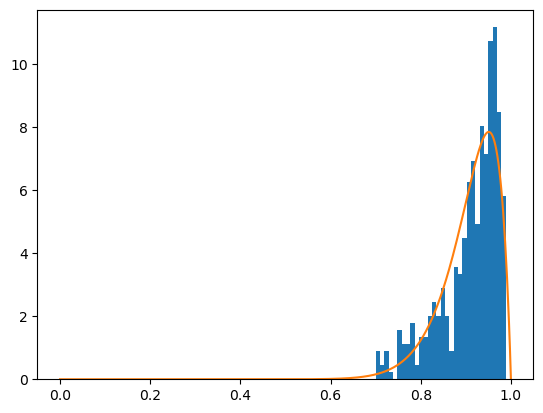

In [80]:
show_map_distribution("1695b31")

{'Hash': '39ea1c7f8ecf7f927e2acd072378bc08c94f230a', 'Name': 'Ringed Genesis', 'CoverImage': 'https://eu.cdn.beatsaver.com/39ea1c7f8ecf7f927e2acd072378bc08c94f230a.jpg', 'Mapper': 'That_Narwhal', 'Id': '1694f71', 'SongId': '1694f', 'ModeName': 'Standard', 'DifficultyName': 'Expert', 'AccRating': 7.834108, 'PassRating': 5.2389383, 'TechRating': 3.3578706, 'PredictedAcc': 0.9822974, 'ModifiersRating': {'Id': 6650, 'SSPredictedAcc': 0.984143, 'SSPassRating': 4.234762, 'SSAccRating': 7.098291, 'SSTechRating': 3.07833, 'SSStars': 5.3992996, 'FSPredictedAcc': 0.98005056, 'FSPassRating': 6.5684013, 'FSAccRating': 8.690171, 'FSTechRating': 3.6086879, 'FSStars': 7.429192, 'SFPredictedAcc': 0.97696817, 'SFPassRating': 8.776032, 'SFAccRating': 9.759354, 'SFTechRating': 3.937448, 'SFStars': 9.110484, 'BFSPredictedAcc': 0.98051697, 'BFSPassRating': 6.6317263, 'BFSAccRating': 8.309429, 'BFSTechRating': 3.618061, 'BFSStars': 7.137729, 'BSFPredictedAcc': 0.9766846, 'BSFPassRating': 8.817675, 'BSFAccRa

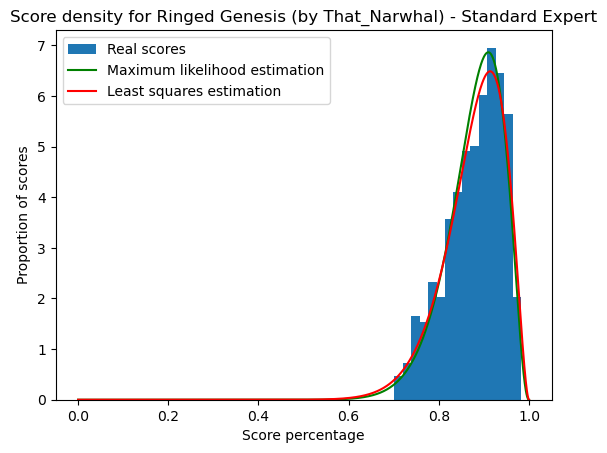

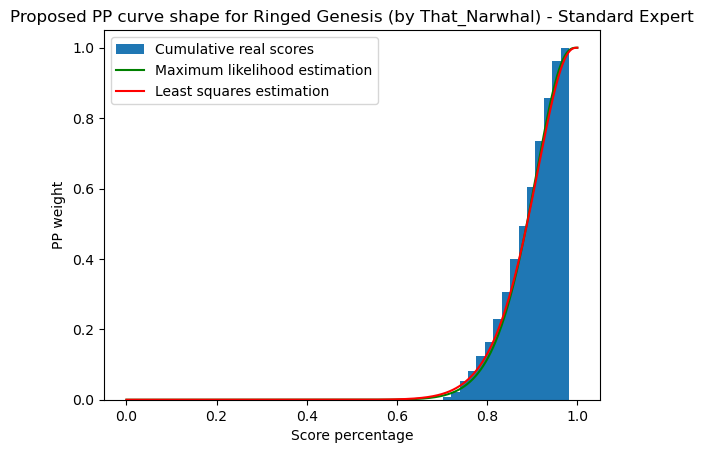

In [181]:
random_map_summary()

In [101]:
fit_scores_beta_least_squares(score_data_by_map_id["1695b31"],beta_parameters_per_map["1695b31"])

array([18.58272426,  1.78339673])

In [126]:
r_squared_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"])

0.9928630870356067

In [145]:
quantiles_beta(least_squares_beta_parameters_per_map["1695b31"],score_data_by_map_id["1695b31"],10)

{0.1: (0.8104506, 0.8286619174684986),
 0.2: (0.8567577, 0.8670281243730755),
 0.3: (0.894665, 0.8914925965919133),
 0.4: (0.9120155, 0.9101713701215169),
 0.5: (0.92767483, 0.925746950095162),
 0.6: (0.94229084, 0.9395092080412275),
 0.7: (0.9536495, 0.9522668033611762),
 0.8: (0.9638578, 0.9647247108616468),
 0.9: (0.9727652, 0.9779453849698194)}

In [185]:
print(best_r_squared_map_id)
print(best_r_squared)

e2ba51
0.9996933996042389


{'Hash': '2e6cb362f31d00ee9f2b9c8640cfd94bbfb8377f', 'Name': 'Astronomia', 'CoverImage': 'https://eu.cdn.beatsaver.com/2e6cb362f31d00ee9f2b9c8640cfd94bbfb8377f.jpg', 'Mapper': 'That_Narwhal', 'Id': 'e2ba51', 'SongId': 'e2ba', 'ModeName': 'Standard', 'DifficultyName': 'Hard', 'AccRating': 6.3108873, 'PassRating': 2.8998866, 'TechRating': 2.2210298, 'PredictedAcc': 0.9861392, 'ModifiersRating': {'Id': 8995, 'SSPredictedAcc': 0.9876936, 'SSPassRating': 2.2833197, 'SSAccRating': 5.730306, 'SSTechRating': 1.9112805, 'SSStars': 3.7183127, 'FSPredictedAcc': 0.9841408, 'FSPassRating': 3.7498677, 'FSAccRating': 7.0991454, 'FSTechRating': 2.5552156, 'FSStars': 5.1944942, 'SFPredictedAcc': 0.9812729, 'SFPassRating': 5.1238756, 'SFAccRating': 8.213132, 'SFTechRating': 2.9561396, 'SFStars': 6.5090494, 'BFSPredictedAcc': 0.9850828, 'BFSPassRating': 3.7834702, 'BFSAccRating': 6.5868015, 'BFSTechRating': 2.5665636, 'BFSStars': 4.819439, 'BSFPredictedAcc': 0.982383, 'BSFPassRating': 5.158939, 'BSFAccRa

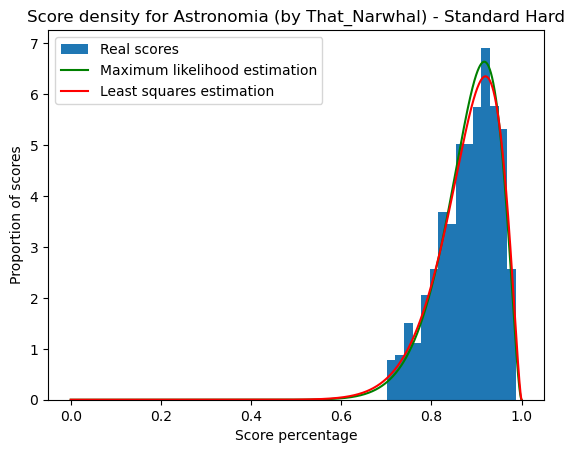

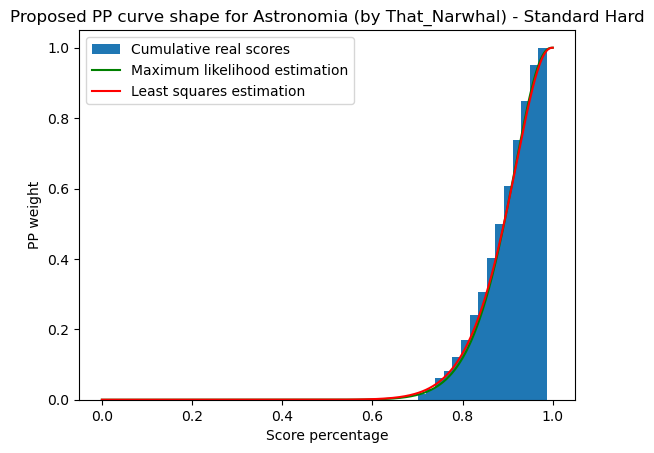

In [186]:
map_summary("e2ba51")

In [187]:
print(worst_r_squared_map_id)
print(worst_r_squared)

1a56811
0.8660639446515537


{'Hash': '5868546dd2a98e6f0bc288a83506eb766113a9eb', 'Name': 'Forever', 'CoverImage': 'https://eu.cdn.beatsaver.com/5868546dd2a98e6f0bc288a83506eb766113a9eb.jpg', 'Mapper': 'Teuflum & muffn', 'Id': '1a56811', 'SongId': '1a568', 'ModeName': 'Standard', 'DifficultyName': 'Easy', 'AccRating': 4.844245, 'PassRating': 0.6914607, 'TechRating': 0.84012985, 'PredictedAcc': 0.9907359, 'ModifiersRating': {'Id': 7059, 'SSPredictedAcc': 0.9913616, 'SSPassRating': 0.52257466, 'SSAccRating': 4.582884, 'SSTechRating': 0.65259993, 'SSStars': 2.3211396, 'FSPredictedAcc': 0.9895627, 'FSPassRating': 0.93920034, 'FSAccRating': 5.305849, 'FSTechRating': 1.0966369, 'FSStars': 2.9676778, 'SFPredictedAcc': 0.987923, 'SFPassRating': 1.3487837, 'SFAccRating': 5.9963307, 'SFTechRating': 1.4765091, 'SFStars': 3.601074, 'BFSPredictedAcc': 0.99013305, 'BFSPassRating': 0.96056956, 'BFSAccRating': 4.680378, 'BFSTechRating': 1.117777, 'BFSStars': 2.565622, 'BSFPredictedAcc': 0.9889618, 'BSFPassRating': 1.3791386, 'BSF

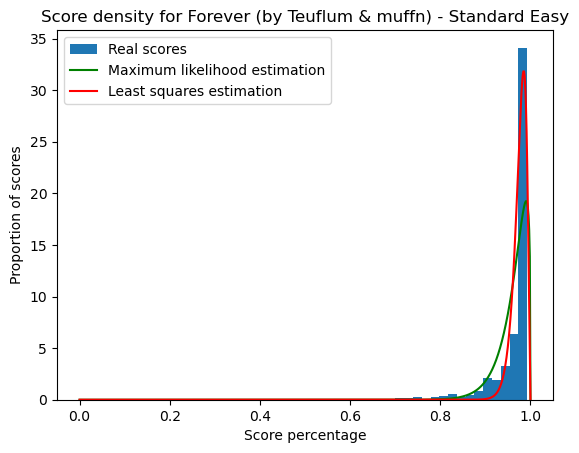

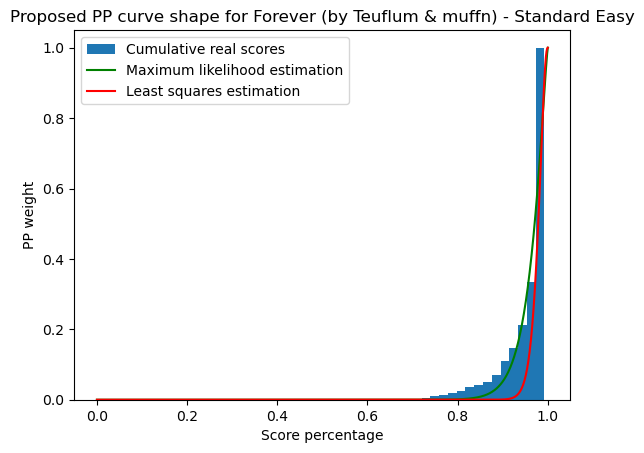

In [188]:
map_summary("1a56811")